In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [0]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
# Normalize data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [0]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [0]:
# Define ResNet block with L2 regularization
def resnet_block(input_data, filters, conv_size, weight_decay=1e-4, dropout_rate=0.2):
    x = Conv2D(filters, conv_size, activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(input_data)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)  # Adding dropout
    x = Conv2D(filters, conv_size, padding='same', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    
    # Ensure the residual connection can be added, if not, use a 1x1 convolution to match dimensions
    if input_data.shape[-1] != filters:
        input_data = Conv2D(filters, (1, 1), activation='relu', padding='same')(input_data)
    
    x = Add()([x, input_data])
    x = Activation('relu')(x)
    return x

In [0]:
def build_resnet(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4))(inputs)  
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Adding more ResNet blocks
    for _ in range(4):  
        x = resnet_block(x, 64, (3, 3))  
    
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)  
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [0]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1  
)
datagen.fit(x_train)

In [0]:
# Learning rate
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

In [0]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=20,
    verbose=1, 
    restore_best_weights=True)

In [0]:
# Build and train the ResNet model
model = build_resnet()
model.summary()  # Display model architecture

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 30, 30, 64)           1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_2 (Bat  (None, 30, 30, 64)           256       ['conv2d_2[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)           0         ['batch_normalization_2[0]

In [0]:
# Train the model with augmented data
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=200, 
    validation_data=(x_test, y_test),
    verbose=2, 
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Epoch 1/200
782/782 - 195s - loss: 1.4705 - accuracy: 0.4878 - val_loss: 1.5788 - val_accuracy: 0.4802 - lr: 0.0010 - 195s/epoch - 250ms/step
Epoch 2/200
782/782 - 187s - loss: 1.1421 - accuracy: 0.6179 - val_loss: 1.2233 - val_accuracy: 0.5968 - lr: 0.0010 - 187s/epoch - 240ms/step
Epoch 3/200
782/782 - 184s - loss: 1.0051 - accuracy: 0.6731 - val_loss: 1.4701 - val_accuracy: 0.5668 - lr: 0.0010 - 184s/epoch - 236ms/step
Epoch 4/200
782/782 - 184s - loss: 0.9220 - accuracy: 0.7080 - val_loss: 1.2689 - val_accuracy: 0.6197 - lr: 0.0010 - 184s/epoch - 235ms/step
Epoch 5/200
782/782 - 185s - loss: 0.8563 - accuracy: 0.7375 - val_loss: 1.6527 - val_accuracy: 0.5239 - lr: 0.0010 - 185s/epoch - 236ms/step
Epoch 6/200
782/782 - 184s - loss: 0.8180 - accuracy: 0.7503 - val_loss: 0.9650 - val_accuracy: 0.7231 - lr: 0.0010 - 184s/epoch - 235ms/step
Epoch 7/200
782/782 - 184s - loss: 0.7884 - accuracy: 0.7669 - val_loss: 0.9056 - val_accuracy: 0.7349 - lr: 0.0010 - 184s/epoch - 235ms/step
Epoch 

INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-49df4-04196-b6981-f/tmp9vrhcz8n/model/data/model/assets


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/2 [00:00<?, ?it/s]

In [0]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy*100:.2f}%")

313/313 [==============================] - 9s 30ms/step - loss: 0.4801 - accuracy: 0.8882
Test accuracy: 88.82%


/root/.ipykernel/1248/command-1522013142959277-1418520744:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


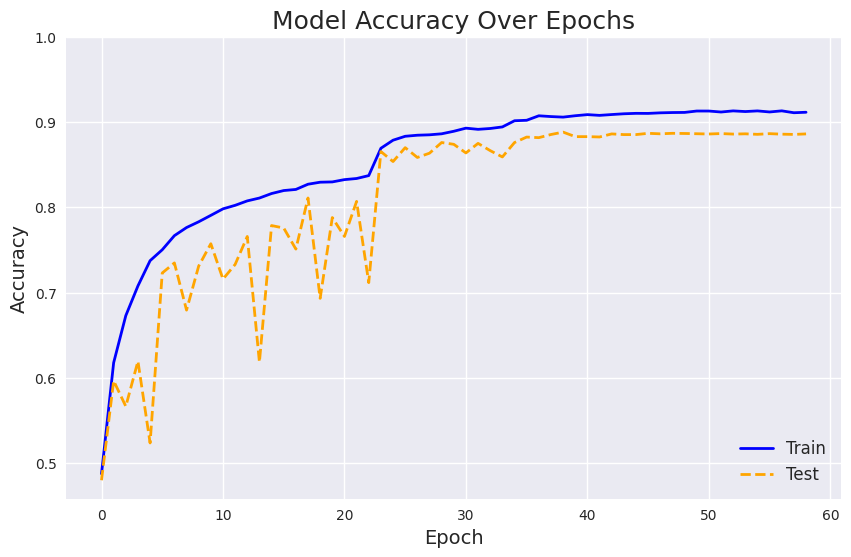

In [0]:
# Plot training & validation accuracy values
plt.style.use('seaborn')
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train', color='blue', linestyle='-', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Test', color='orange', linestyle='--', linewidth=2)
plt.title('Model Accuracy Over Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylim([min(plt.ylim()),1])
plt.legend(loc='lower right', fontsize=12)
sns.despine()
plt.show()

/root/.ipykernel/1248/command-1522013142959283-2814804683:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


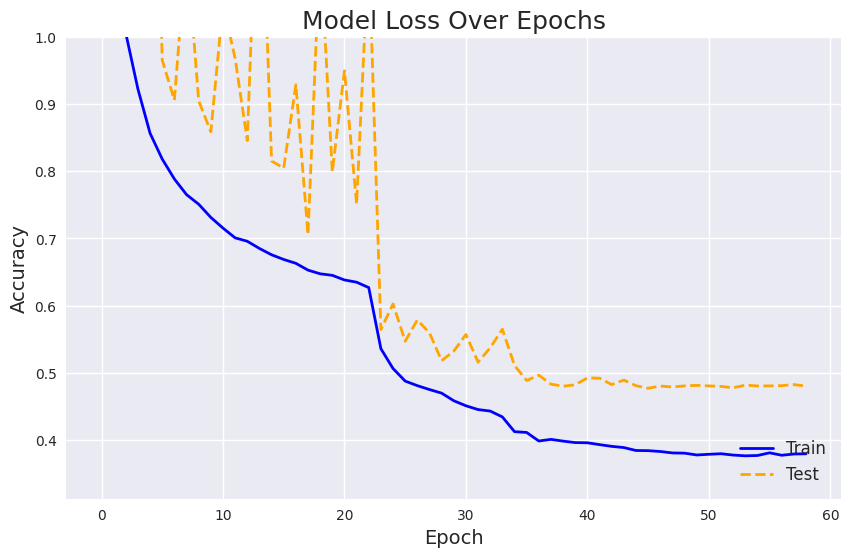

In [0]:
# Plot training & validation accuracy values
plt.style.use('seaborn')
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train', color='blue', linestyle='-', linewidth=2)
plt.plot(history.history['val_loss'], label='Test', color='orange', linestyle='--', linewidth=2)
plt.title('Model Loss Over Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylim([min(plt.ylim()),1])
plt.legend(loc='lower right', fontsize=12)
sns.despine()
plt.show()

In [0]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

313/313 [==============================] - 9s 29ms/step


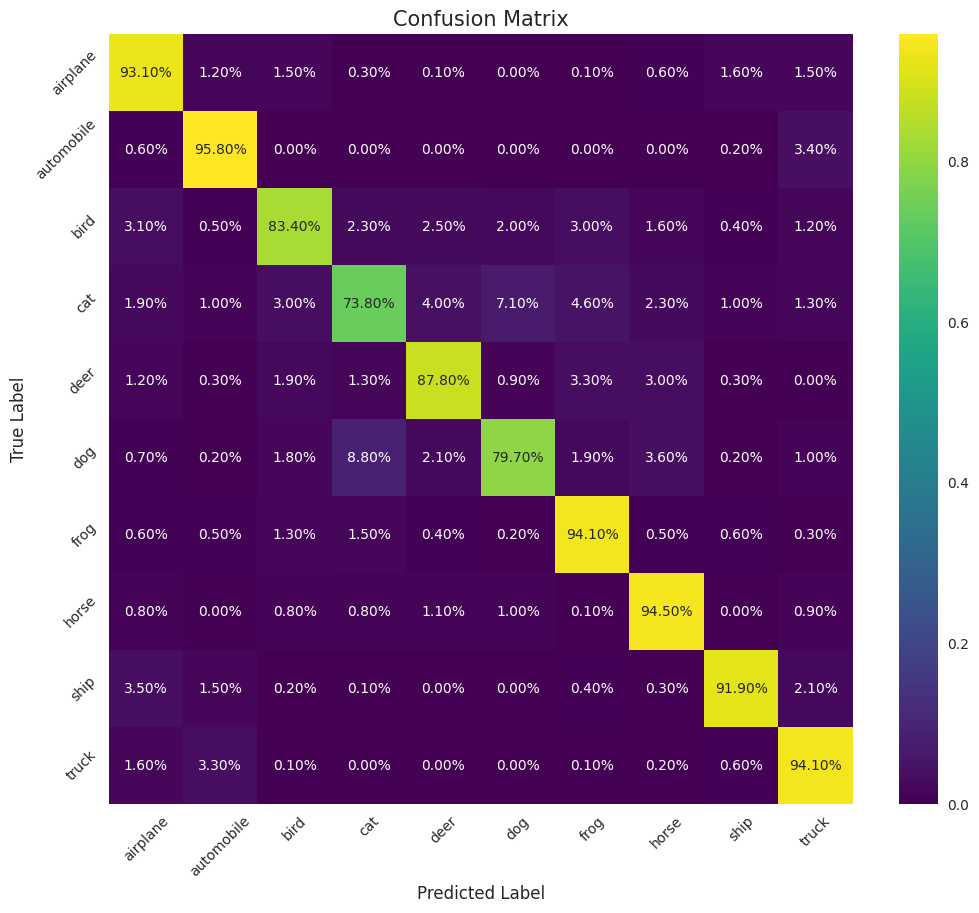

In [0]:
# Confusion Matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 10))  # Larger figure size
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='viridis', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label', fontsize=12)  
plt.ylabel('True Label', fontsize=12)      
plt.title('Confusion Matrix', fontsize=15)  
plt.xticks(rotation=45)  
plt.yticks(rotation=45)  
plt.show()